# Qualitative Illustrations of Results 

In [1]:
# import relevant packages 
from src.model.wavelet_model import * 
from matplotlib import pyplot as plt 
from scipy.signal import find_peaks
import seaborn as sns 
import numpy as np 
import pickle 

np.random.seed(seed = 0)

sns.set_theme()

rcParams = {
    "font.family": "serif",  # use serif/main font for text elements
    'text.usetex': True,
    'font.size': 8,
    'axes.labelsize': 7,
    'axes.titlesize': 9,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 7,
    'axes.labelpad': 1,
    'axes.axisbelow': True,  # draw gridlines below other elements
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": "\n".join([
        r"\usepackage{url}",            # load additional packages
        r"\usepackage{amsmath,amssymb}",   # unicode math setup
        #  r"\setmainfont{DejaVu Serif}",  # serif font via preamble
    ])
}
plt.rcParams.update(rcParams)

figdir = "../../../figures/results/"
def savefig(fig, name, width=6, height=4):
    # apply rcParams
    fig.set_size_inches(width, height)
    fig.savefig(figdir + name + ".pdf", bbox_inches='tight')


### Read data 

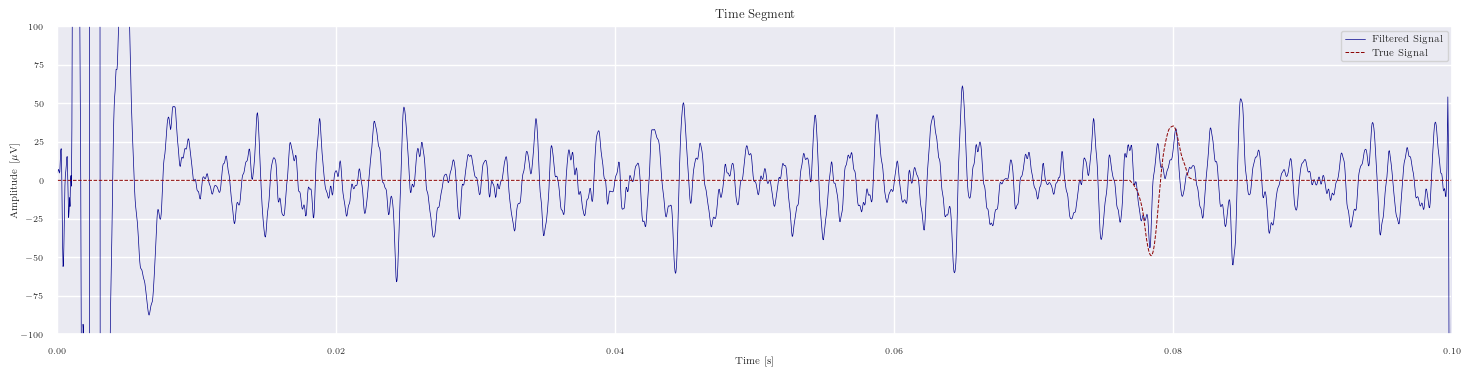

In [ ]:
with open("simulated_data.pkl", "rb") as file: 
    data = pickle.load(file)
file.close()

filtered_signal = data['filt_signal']
true_signal = data['true_signal']
x_axis = np.arange(len(filtered_signal)) / 30000
channel = 2

fig, ax = plt.subplots(1, 1, figsize = (18, 4))
ax.plot(x_axis, filtered_signal[:, channel], color = "darkblue", linewidth = 0.5, label = "Filtered Signal")
ax.plot(x_axis, true_signal[:, channel], "--", color = "darkred", linewidth = 0.7, label = "True Signal")
ax.legend()
ax.set_xlim([0, 0.1])
ax.set_ylim([-100, 100])
ax.set_xlabel("Time [s]")
ax.set_ylabel(r"Amplitude [$\mu$V]")
ax.set_title("Time Segment")
plt.show()


savefig(fig, "qual_time_segment", width = 6.5, height=1.5)

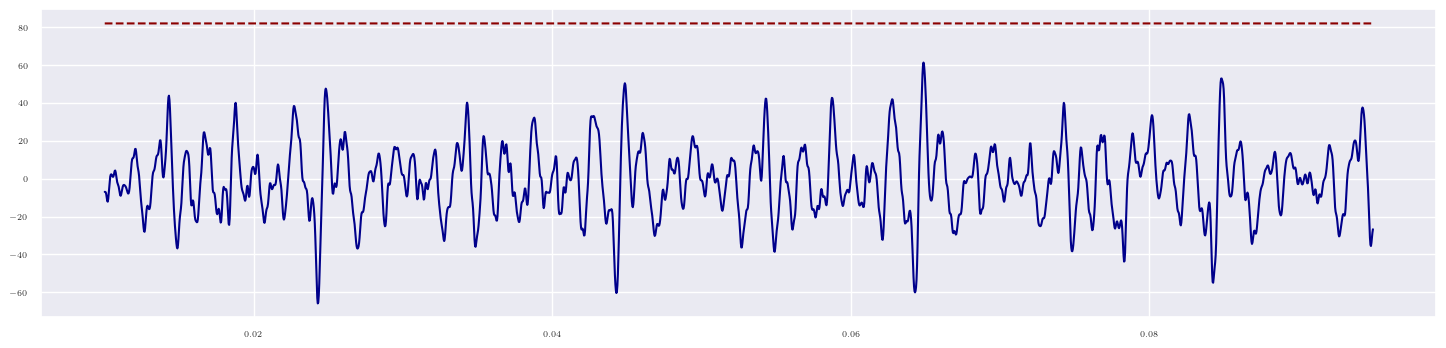

In [ ]:
bin = filtered_signal[(x_axis > 0.01) & (x_axis < 0.095), channel]
T = 4.5 * np.sqrt(np.mean(bin**2))
plt.figure(figsize = (18, 4))
plt.plot(x_axis[(x_axis > 0.01) & (x_axis < 0.095)], bin, color = "darkblue")
plt.plot(x_axis[(x_axis > 0.01) & (x_axis < 0.095)], np.ones(len(bin))*T, "--", color ="darkred")
plt.show()

### Get Scalograms 

In [3]:
 # find the SA and bin accordingly
peaks, _ = find_peaks(filtered_signal[:, channel], height = 300, distance = 2900)
bins = bin_data(filtered_signal[:, channel], peaks).T 

scalograms = np.zeros((bins.shape[1], 127, 2400))

# loop over all bins
for bin_idx in range(bins.shape[1]):
    # apply wavelet transform
    coefficients, frequencies = pywt.cwt(bins[:, bin_idx], scales=np.arange(1, 128), wavelet='cgau1', sampling_period=1/30000)

    # save the scalograms
    scalograms[bin_idx] = np.abs(coefficients)

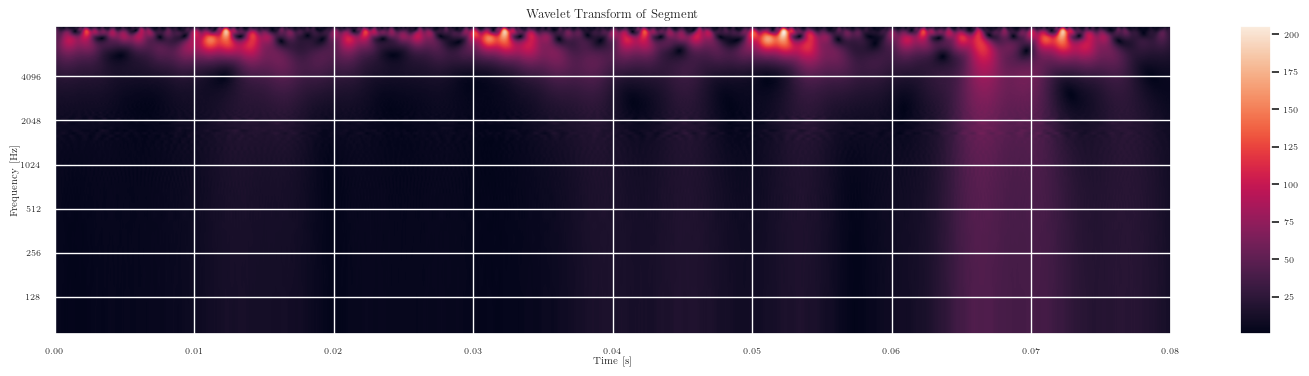

In [4]:
fig = plt.figure(figsize = (18, 4))
plt.imshow(np.flipud(scalograms[0]), extent=[0, len(bins) / 30000, frequencies.min(), frequencies.max()],
           aspect='auto', origin='lower')
plt.colorbar(aspect=10)
plt.yscale("log")
plt.yticks([128, 256, 512, 1024, 2048, 4096], ["128", "256", "512", "1024", "2048", "4096"])
plt.title("Wavelet Transform of Segment")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.show()

savefig(fig, "qual_coefs_orig", width = 6.5, height=1.5)

### Clean Scalograms 

In [5]:
scaloegrams_clean = clean_scalograms(scalograms)

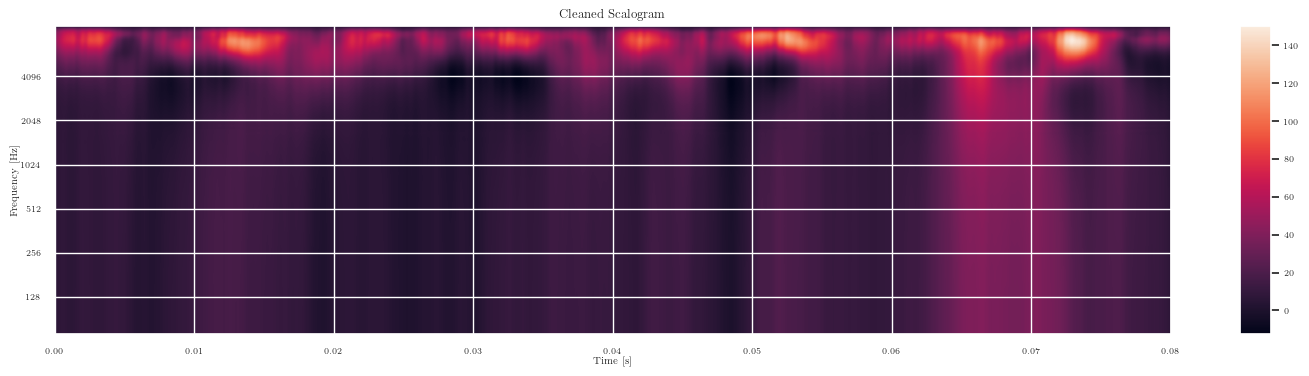

In [6]:
fig = plt.figure(figsize = (18, 4))
plt.imshow(np.flipud(scaloegrams_clean[0]), extent=[0, len(bins) / 30000, frequencies.min(), frequencies.max()],
           aspect='auto', origin='lower')
plt.colorbar(aspect=10)
plt.yscale("log")
plt.yticks([128, 256, 512, 1024, 2048, 4096], ["128", "256", "512", "1024", "2048", "4096"])
plt.title("Cleaned Scalogram")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.show()

savefig(fig, "qual_coefs_denoised", width = 6.5, height=1.5)

### Get Accepted Coefficients 

In [7]:
accept_coefs = get_accepted_coefficients(scaloegrams_clean[0], np.arange(1, 128), 0.2)

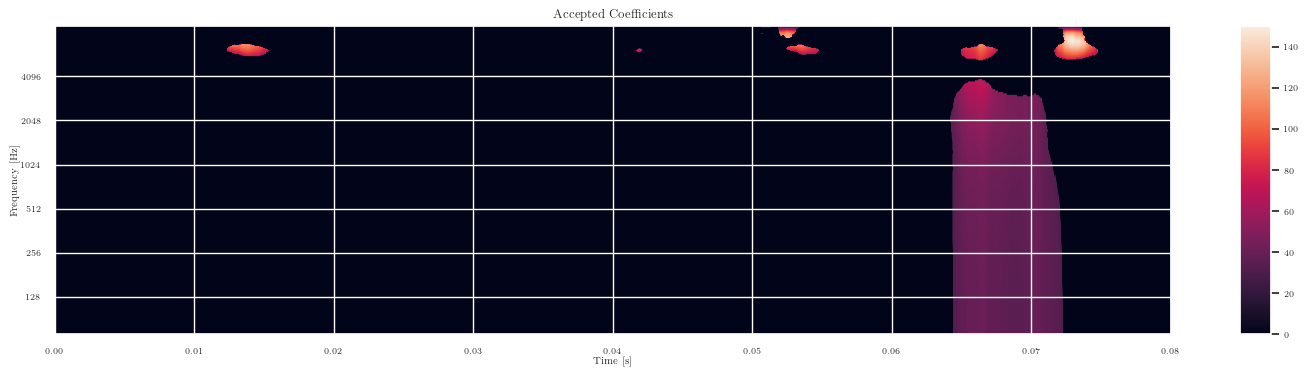

In [8]:
fig = plt.figure(figsize = (18, 4))
plt.imshow(np.flipud(accept_coefs), extent=[0, len(bins) / 30000, frequencies.min(), frequencies.max()],
           aspect='auto', origin='lower')
plt.colorbar(aspect=10)
plt.yscale("log")
plt.yticks([128, 256, 512, 1024, 2048, 4096], ["128", "256", "512", "1024", "2048", "4096"])
plt.title("Accepted Coefficients")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.show()

savefig(fig, "qual_coefs_accept", width = 6.5, height=1.5)

## Threshold and spontaneous data 

### Read Data 

In [2]:
with open("simulated_data_spon.pkl", "rb") as file: 
    data = pickle.load(file)
file.close()

obs_signal = data['obs_signal']
true_signal = data['true_signal']
filtered_signal = data['filtered_signal']
CAP_indices = data['CAP_indices']

x_axis = np.arange(len(obs_signal)) / 30000 

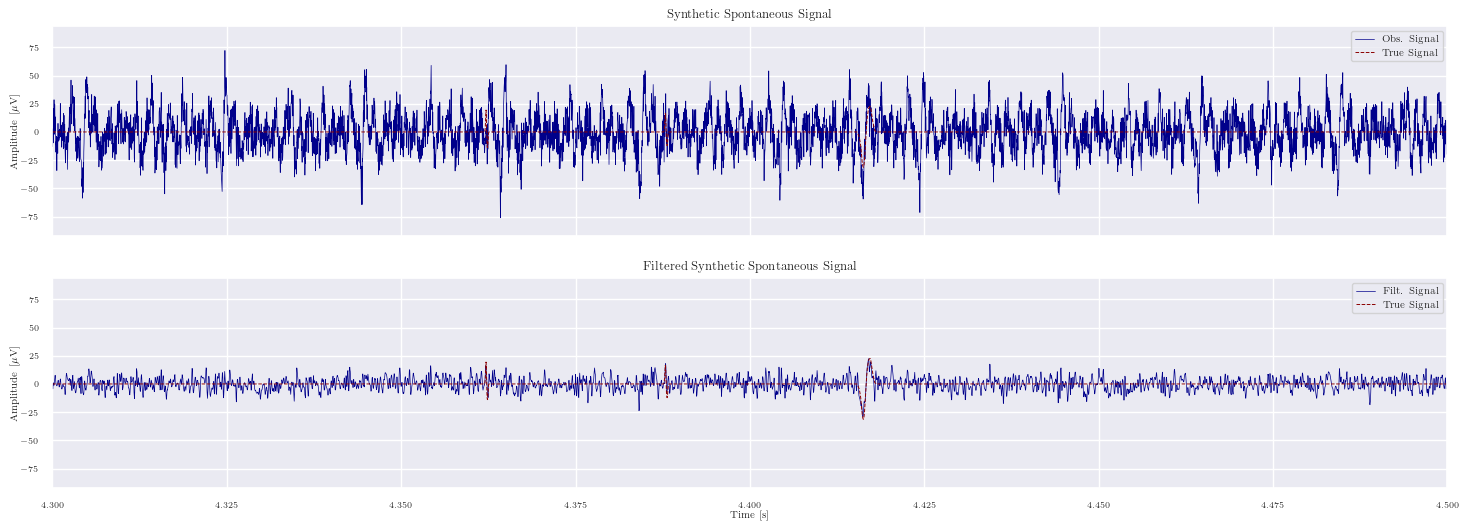

In [13]:
channel = 1

fig, ax = plt.subplots(2, 1, figsize = (18, 6), sharey = True, sharex=True)
ax[0].plot(x_axis, obs_signal[:, channel], color = "darkblue", label = "Obs. Signal", linewidth = 0.5)
ax[0].plot(x_axis, true_signal[:, channel], "--", color = "darkred", label = "True Signal", linewidth = 0.7)
ax[0].set_title("Synthetic Spontaneous Signal")
ax[1].plot(x_axis, filtered_signal[:, channel], color = "darkblue", label = "Filt. Signal", linewidth = 0.5)
ax[1].plot(x_axis, true_signal[:, channel], "--", color = "darkred", label = "True Signal", linewidth = 0.7)
ax[1].set_title("Filtered Synthetic Spontaneous Signal")
ax[1].set_xlabel("Time [s]")

[a.set_xlim([4.3, 4.5]) for a in ax]
[a.set_ylabel(r"Amplitude [$\mu$V]") for a in ax]
[a.legend() for a in ax]
plt.show()

savefig(fig, "qual_spon_time_series", width = 6.5, height=2.5)

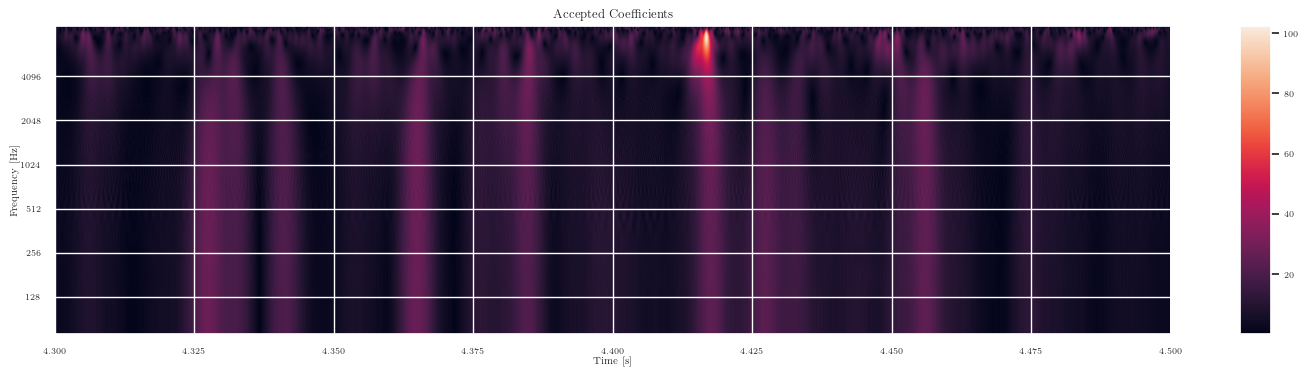

In [15]:
segment = filtered_signal[(x_axis > 4.3) & (x_axis < 4.5), channel]
coefficients, frequencies = pywt.cwt(segment, scales=np.arange(1, 128), wavelet='cgau1', sampling_period=1/30000)

fig = plt.figure(figsize = (18, 4))
plt.imshow(np.flipud(np.abs(coefficients)), extent=[4.3, 4.5, frequencies.min(), frequencies.max()],
           aspect='auto', origin='lower')
plt.colorbar(aspect=10)
plt.yscale("log")
plt.yticks([128, 256, 512, 1024, 2048, 4096], ["128", "256", "512", "1024", "2048", "4096"])
plt.title("Accepted Coefficients")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.show()

savefig(fig, "qual_spon_scalogram", width = 6.5, height=1.5)

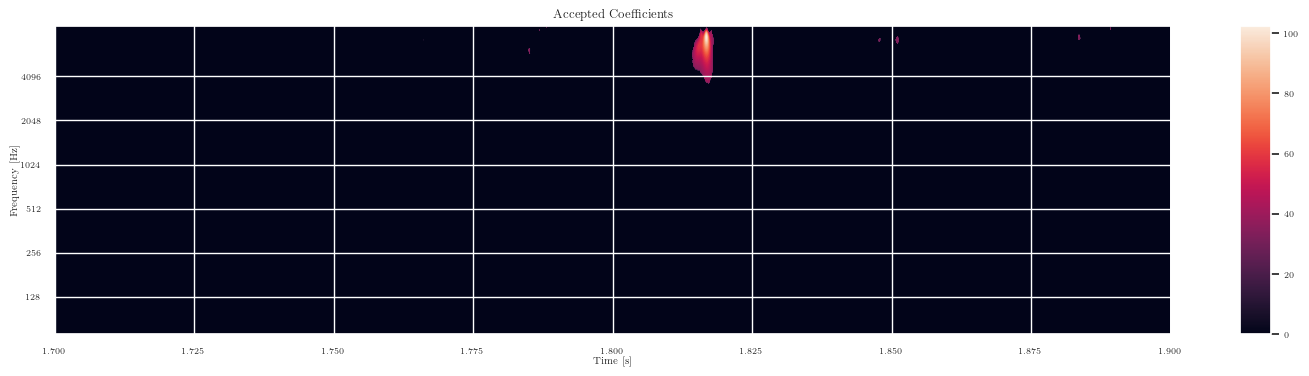

1


In [12]:
accept_coefs = get_accepted_coefficients(np.abs(coefficients), np.arange(1, 128), 0.3)

fig = plt.figure(figsize = (18, 4))
plt.imshow(np.flipud(accept_coefs), extent=[1.7, 1.9, frequencies.min(), frequencies.max()],
           aspect='auto', origin='lower')
plt.colorbar(aspect=10)
plt.yscale("log")
plt.yticks([128, 256, 512, 1024, 2048, 4096], ["128", "256", "512", "1024", "2048", "4096"])
plt.title("Accepted Coefficients")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.show()

spike_indicators = get_spike_indicators(accept_coefs)
TE = parse(spike_indicators, 30, (0.5, 5))
print(len(TE))

0.0